# Digital Filter Design

## Introduction

Digital filters are fundamental components in signal processing, used to modify or extract specific frequency components from discrete-time signals. This notebook explores the theory and practical implementation of both **Infinite Impulse Response (IIR)** and **Finite Impulse Response (FIR)** filters.

## Theoretical Foundation

### Discrete-Time Systems

A discrete-time linear time-invariant (LTI) system is characterized by its difference equation:

$$y[n] = \sum_{k=0}^{M} b_k x[n-k] - \sum_{k=1}^{N} a_k y[n-k]$$

where $x[n]$ is the input signal, $y[n]$ is the output signal, $b_k$ are the feedforward coefficients, and $a_k$ are the feedback coefficients.

### Transfer Function

The **z-transform** of the difference equation yields the transfer function:

$$H(z) = \frac{Y(z)}{X(z)} = \frac{\sum_{k=0}^{M} b_k z^{-k}}{1 + \sum_{k=1}^{N} a_k z^{-k}}$$

### Frequency Response

The frequency response is obtained by evaluating the transfer function on the unit circle ($z = e^{j\omega}$):

$$H(e^{j\omega}) = |H(e^{j\omega})| e^{j\phi(\omega)}$$

where $|H(e^{j\omega})|$ is the **magnitude response** and $\phi(\omega)$ is the **phase response**.

## Filter Types

### FIR Filters

FIR filters have $a_k = 0$ for all $k \geq 1$, resulting in:

$$y[n] = \sum_{k=0}^{M} b_k x[n-k]$$

**Advantages:**
- Always stable
- Can have exact linear phase
- No feedback required

### IIR Filters

IIR filters include feedback terms, allowing for sharper frequency selectivity with fewer coefficients. Common design methods include:

- **Butterworth**: Maximally flat passband
- **Chebyshev Type I**: Equiripple passband
- **Chebyshev Type II**: Equiripple stopband
- **Elliptic**: Equiripple in both bands

### Filter Specifications

Key parameters for filter design:

- **Passband edge frequency** ($\omega_p$): Upper limit of passband
- **Stopband edge frequency** ($\omega_s$): Lower limit of stopband
- **Passband ripple** ($\delta_p$): Maximum deviation in passband (dB)
- **Stopband attenuation** ($\delta_s$): Minimum attenuation in stopband (dB)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Set random seed for reproducibility
np.random.seed(42)

# Sampling parameters
fs = 1000  # Sampling frequency (Hz)
T = 1.0    # Duration (seconds)
n_samples = int(fs * T)
t = np.linspace(0, T, n_samples, endpoint=False)

print(f"Sampling frequency: {fs} Hz")
print(f"Nyquist frequency: {fs/2} Hz")
print(f"Number of samples: {n_samples}")

Sampling frequency: 1000 Hz
Nyquist frequency: 500.0 Hz
Number of samples: 1000


## Test Signal Generation

We create a composite signal containing multiple frequency components:

$$x(t) = A_1 \sin(2\pi f_1 t) + A_2 \sin(2\pi f_2 t) + A_3 \sin(2\pi f_3 t) + \eta(t)$$

where $\eta(t)$ represents additive white Gaussian noise.

In [2]:
# Generate composite test signal
f1, A1 = 10, 1.0    # Low frequency component
f2, A2 = 50, 0.5    # Mid frequency component
f3, A3 = 200, 0.3   # High frequency component

# Clean signal components
signal_low = A1 * np.sin(2 * np.pi * f1 * t)
signal_mid = A2 * np.sin(2 * np.pi * f2 * t)
signal_high = A3 * np.sin(2 * np.pi * f3 * t)

# Add noise
noise = 0.2 * np.random.randn(n_samples)

# Composite signal
x = signal_low + signal_mid + signal_high + noise

print(f"Signal components: {f1} Hz, {f2} Hz, {f3} Hz")
print(f"Signal SNR estimate: {10*np.log10(np.var(signal_low + signal_mid + signal_high)/np.var(noise)):.2f} dB")

Signal components: 10 Hz, 50 Hz, 200 Hz
Signal SNR estimate: 12.43 dB


## Butterworth Lowpass Filter Design

The Butterworth filter is characterized by a maximally flat magnitude response in the passband. The magnitude squared response is:

$$|H(j\Omega)|^2 = \frac{1}{1 + \left(\frac{\Omega}{\Omega_c}\right)^{2N}}$$

where $N$ is the filter order and $\Omega_c$ is the cutoff frequency.

In [3]:
# Design Butterworth lowpass filter
# Goal: Pass 10 Hz, attenuate 50 Hz and above

cutoff_freq = 30  # Cutoff frequency (Hz)
filter_order = 4

# Normalize cutoff frequency to Nyquist
Wn = cutoff_freq / (fs / 2)

# Design filter
b_butter, a_butter = signal.butter(filter_order, Wn, btype='low')

print(f"Butterworth Lowpass Filter (Order {filter_order})")
print(f"Cutoff frequency: {cutoff_freq} Hz")
print(f"Normalized frequency: {Wn:.4f}")
print(f"\nNumerator coefficients (b): {b_butter}")
print(f"Denominator coefficients (a): {a_butter}")

Butterworth Lowpass Filter (Order 4)
Cutoff frequency: 30 Hz
Normalized frequency: 0.0600

Numerator coefficients (b): [6.23869835e-05 2.49547934e-04 3.74321901e-04 2.49547934e-04
 6.23869835e-05]
Denominator coefficients (a): [ 1.         -3.50778621  4.64090241 -2.74265282  0.61053481]


In [4]:
# Compute frequency response
w_butter, h_butter = signal.freqz(b_butter, a_butter, worN=2048, fs=fs)

# Magnitude in dB
mag_butter_db = 20 * np.log10(np.abs(h_butter) + 1e-10)

# Phase in degrees
phase_butter = np.unwrap(np.angle(h_butter)) * 180 / np.pi

## Chebyshev Type I Bandpass Filter Design

Chebyshev Type I filters allow ripple in the passband to achieve a steeper roll-off. The magnitude squared response is:

$$|H(j\Omega)|^2 = \frac{1}{1 + \epsilon^2 T_N^2\left(\frac{\Omega}{\Omega_c}\right)}$$

where $T_N$ is the Chebyshev polynomial of degree $N$ and $\epsilon$ determines the passband ripple.

In [5]:
# Design Chebyshev Type I bandpass filter
# Goal: Pass around 50 Hz

lowcut = 40   # Lower cutoff (Hz)
highcut = 60  # Upper cutoff (Hz)
ripple_db = 1  # Passband ripple (dB)
cheby_order = 4

# Normalize frequencies
low_norm = lowcut / (fs / 2)
high_norm = highcut / (fs / 2)

# Design filter
b_cheby, a_cheby = signal.cheby1(cheby_order, ripple_db, [low_norm, high_norm], btype='band')

print(f"Chebyshev Type I Bandpass Filter (Order {cheby_order})")
print(f"Passband: {lowcut} - {highcut} Hz")
print(f"Passband ripple: {ripple_db} dB")

# Compute frequency response
w_cheby, h_cheby = signal.freqz(b_cheby, a_cheby, worN=2048, fs=fs)
mag_cheby_db = 20 * np.log10(np.abs(h_cheby) + 1e-10)
phase_cheby = np.unwrap(np.angle(h_cheby)) * 180 / np.pi

Chebyshev Type I Bandpass Filter (Order 4)
Passband: 40 - 60 Hz
Passband ripple: 1 dB


## FIR Filter Design using Window Method

The window method designs FIR filters by truncating the ideal impulse response and applying a window function:

$$h[n] = h_d[n] \cdot w[n]$$

where $h_d[n]$ is the ideal (infinite) impulse response and $w[n]$ is the window function.

For an ideal lowpass filter:

$$h_d[n] = \frac{\sin(\omega_c n)}{\pi n}$$

In [6]:
# Design FIR highpass filter using window method
# Goal: Pass frequencies above 150 Hz

fir_cutoff = 150  # Cutoff frequency (Hz)
num_taps = 101    # Number of filter coefficients (odd for Type I)

# Normalize cutoff
fir_norm = fir_cutoff / (fs / 2)

# Design filter with Hamming window
b_fir = signal.firwin(num_taps, fir_norm, pass_zero=False, window='hamming')
a_fir = [1.0]  # FIR filter has no feedback

print(f"FIR Highpass Filter")
print(f"Number of taps: {num_taps}")
print(f"Cutoff frequency: {fir_cutoff} Hz")
print(f"Window: Hamming")

# Compute frequency response
w_fir, h_fir = signal.freqz(b_fir, a_fir, worN=2048, fs=fs)
mag_fir_db = 20 * np.log10(np.abs(h_fir) + 1e-10)
phase_fir = np.unwrap(np.angle(h_fir)) * 180 / np.pi

FIR Highpass Filter
Number of taps: 101
Cutoff frequency: 150 Hz
Window: Hamming


## Apply Filters to Test Signal

In [7]:
# Apply filters using filtfilt for zero-phase filtering
y_butter = signal.filtfilt(b_butter, a_butter, x)
y_cheby = signal.filtfilt(b_cheby, a_cheby, x)
y_fir = signal.filtfilt(b_fir, a_fir, x)

print("Filters applied successfully using zero-phase filtering (filtfilt)")

Filters applied successfully using zero-phase filtering (filtfilt)


## Spectral Analysis

We analyze the frequency content before and after filtering using the Discrete Fourier Transform:

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N}$$

In [8]:
# Compute FFT of signals
def compute_spectrum(sig, n_samples, fs):
    """Compute single-sided amplitude spectrum."""
    fft_vals = fft(sig)
    freqs = fftfreq(n_samples, 1/fs)
    
    # Single-sided spectrum
    pos_mask = freqs >= 0
    freqs_pos = freqs[pos_mask]
    magnitude = 2.0 / n_samples * np.abs(fft_vals[pos_mask])
    magnitude[0] /= 2  # DC component
    
    return freqs_pos, magnitude

# Compute spectra
freqs_orig, spec_orig = compute_spectrum(x, n_samples, fs)
freqs_butter, spec_butter = compute_spectrum(y_butter, n_samples, fs)
freqs_cheby, spec_cheby = compute_spectrum(y_cheby, n_samples, fs)
freqs_fir, spec_fir = compute_spectrum(y_fir, n_samples, fs)

## Visualization

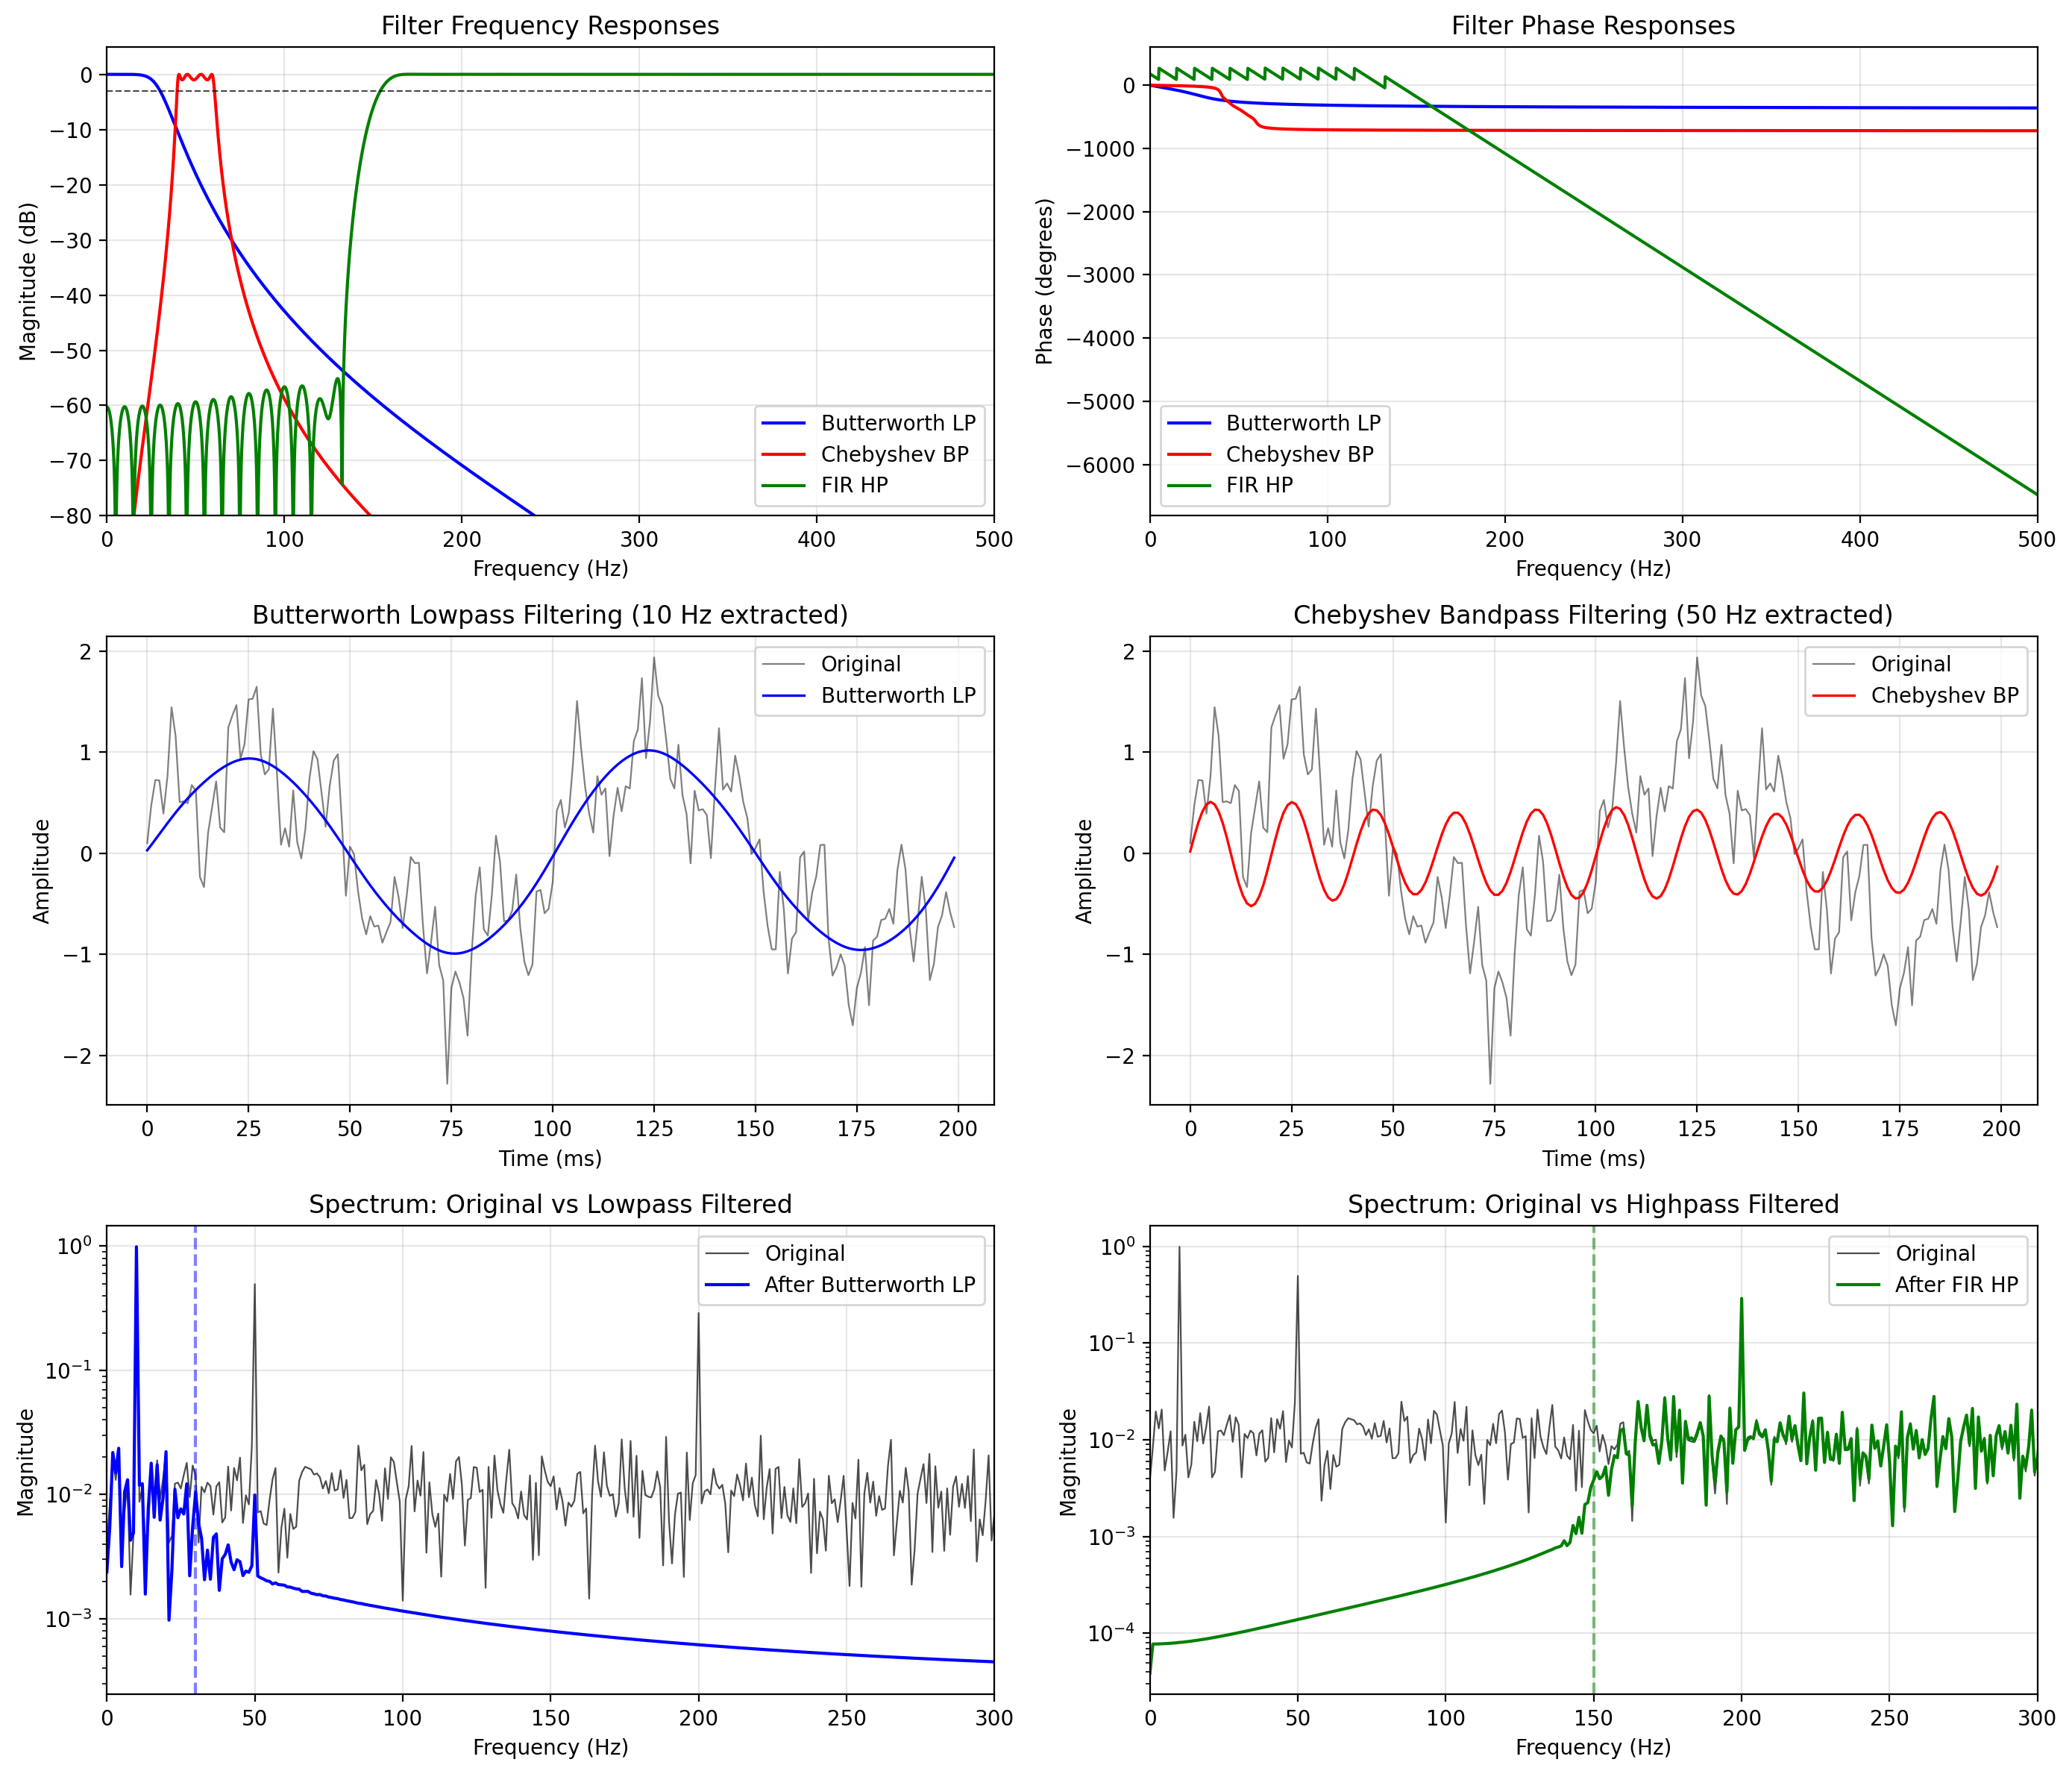


Plot saved to 'plot.png'


In [9]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 12))

# --- Row 1: Filter Frequency Responses ---
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(w_butter, mag_butter_db, 'b-', linewidth=1.5, label='Butterworth LP')
ax1.plot(w_cheby, mag_cheby_db, 'r-', linewidth=1.5, label='Chebyshev BP')
ax1.plot(w_fir, mag_fir_db, 'g-', linewidth=1.5, label='FIR HP')
ax1.axhline(y=-3, color='k', linestyle='--', linewidth=0.8, alpha=0.7)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Filter Frequency Responses')
ax1.set_xlim([0, fs/2])
ax1.set_ylim([-80, 5])
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Row 1: Phase Responses ---
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(w_butter, phase_butter, 'b-', linewidth=1.5, label='Butterworth LP')
ax2.plot(w_cheby, phase_cheby, 'r-', linewidth=1.5, label='Chebyshev BP')
ax2.plot(w_fir, phase_fir, 'g-', linewidth=1.5, label='FIR HP')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.set_title('Filter Phase Responses')
ax2.set_xlim([0, fs/2])
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# --- Row 2: Time Domain Signals ---
ax3 = fig.add_subplot(3, 2, 3)
t_plot = t[:200]  # First 200 ms
ax3.plot(t_plot*1000, x[:200], 'k-', linewidth=0.8, alpha=0.5, label='Original')
ax3.plot(t_plot*1000, y_butter[:200], 'b-', linewidth=1.2, label='Butterworth LP')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Amplitude')
ax3.set_title('Butterworth Lowpass Filtering (10 Hz extracted)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(t_plot*1000, x[:200], 'k-', linewidth=0.8, alpha=0.5, label='Original')
ax4.plot(t_plot*1000, y_cheby[:200], 'r-', linewidth=1.2, label='Chebyshev BP')
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Amplitude')
ax4.set_title('Chebyshev Bandpass Filtering (50 Hz extracted)')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# --- Row 3: Frequency Domain Analysis ---
ax5 = fig.add_subplot(3, 2, 5)
ax5.semilogy(freqs_orig, spec_orig, 'k-', linewidth=0.8, alpha=0.7, label='Original')
ax5.semilogy(freqs_butter, spec_butter, 'b-', linewidth=1.5, label='After Butterworth LP')
ax5.axvline(x=cutoff_freq, color='b', linestyle='--', alpha=0.5)
ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('Magnitude')
ax5.set_title('Spectrum: Original vs Lowpass Filtered')
ax5.set_xlim([0, 300])
ax5.legend(loc='best')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(3, 2, 6)
ax6.semilogy(freqs_orig, spec_orig, 'k-', linewidth=0.8, alpha=0.7, label='Original')
ax6.semilogy(freqs_fir, spec_fir, 'g-', linewidth=1.5, label='After FIR HP')
ax6.axvline(x=fir_cutoff, color='g', linestyle='--', alpha=0.5)
ax6.set_xlabel('Frequency (Hz)')
ax6.set_ylabel('Magnitude')
ax6.set_title('Spectrum: Original vs Highpass Filtered')
ax6.set_xlim([0, 300])
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('digital_filter_design_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Filter Performance Analysis

In [10]:
# Quantitative analysis
print("=" * 60)
print("FILTER PERFORMANCE SUMMARY")
print("=" * 60)

# Original signal power at each frequency
def get_power_at_freq(spec, freqs, target_freq, bandwidth=5):
    """Get signal power around target frequency."""
    mask = (freqs >= target_freq - bandwidth) & (freqs <= target_freq + bandwidth)
    return np.max(spec[mask]) if np.any(mask) else 0

print("\nOriginal Signal Components:")
print(f"  10 Hz: {get_power_at_freq(spec_orig, freqs_orig, 10):.4f}")
print(f"  50 Hz: {get_power_at_freq(spec_orig, freqs_orig, 50):.4f}")
print(f" 200 Hz: {get_power_at_freq(spec_orig, freqs_orig, 200):.4f}")

print("\nButterworth Lowpass (fc=30 Hz):")
print(f"  10 Hz: {get_power_at_freq(spec_butter, freqs_butter, 10):.4f} (passed)")
print(f"  50 Hz: {get_power_at_freq(spec_butter, freqs_butter, 50):.4f} (attenuated)")
print(f" 200 Hz: {get_power_at_freq(spec_butter, freqs_butter, 200):.6f} (attenuated)")

print("\nChebyshev Bandpass (40-60 Hz):")
print(f"  10 Hz: {get_power_at_freq(spec_cheby, freqs_cheby, 10):.6f} (attenuated)")
print(f"  50 Hz: {get_power_at_freq(spec_cheby, freqs_cheby, 50):.4f} (passed)")
print(f" 200 Hz: {get_power_at_freq(spec_cheby, freqs_cheby, 200):.6f} (attenuated)")

print("\nFIR Highpass (fc=150 Hz):")
print(f"  10 Hz: {get_power_at_freq(spec_fir, freqs_fir, 10):.6f} (attenuated)")
print(f"  50 Hz: {get_power_at_freq(spec_fir, freqs_fir, 50):.6f} (attenuated)")
print(f" 200 Hz: {get_power_at_freq(spec_fir, freqs_fir, 200):.4f} (passed)")

print("\n" + "=" * 60)

FILTER PERFORMANCE SUMMARY

Original Signal Components:
  10 Hz: 0.9893
  50 Hz: 0.4948
 200 Hz: 0.2895

Butterworth Lowpass (fc=30 Hz):
  10 Hz: 0.9891 (passed)
  50 Hz: 0.0099 (attenuated)
 200 Hz: 0.000630 (attenuated)

Chebyshev Bandpass (40-60 Hz):
  10 Hz: 0.003340 (attenuated)
  50 Hz: 0.3979 (passed)
 200 Hz: 0.000213 (attenuated)

FIR Highpass (fc=150 Hz):
  10 Hz: 0.000084 (attenuated)
  50 Hz: 0.000151 (attenuated)
 200 Hz: 0.2892 (passed)



## Pole-Zero Analysis

In [11]:
# Analyze stability through pole locations
print("\nSTABILITY ANALYSIS (Pole Locations)")
print("=" * 60)

# Butterworth poles
zeros_b, poles_b, gain_b = signal.tf2zpk(b_butter, a_butter)
max_pole_mag_b = np.max(np.abs(poles_b))
print(f"\nButterworth Filter:")
print(f"  Number of poles: {len(poles_b)}")
print(f"  Max pole magnitude: {max_pole_mag_b:.6f}")
print(f"  Stable: {max_pole_mag_b < 1}")

# Chebyshev poles
zeros_c, poles_c, gain_c = signal.tf2zpk(b_cheby, a_cheby)
max_pole_mag_c = np.max(np.abs(poles_c))
print(f"\nChebyshev Filter:")
print(f"  Number of poles: {len(poles_c)}")
print(f"  Max pole magnitude: {max_pole_mag_c:.6f}")
print(f"  Stable: {max_pole_mag_c < 1}")

# FIR has no poles (all at origin)
print(f"\nFIR Filter:")
print(f"  Number of taps: {len(b_fir)}")
print(f"  All poles at z=0 (always stable)")


STABILITY ANALYSIS (Pole Locations)

Butterworth Filter:
  Number of poles: 4
  Max pole magnitude: 0.930688
  Stable: True

Chebyshev Filter:
  Number of poles: 8
  Max pole magnitude: 0.992947
  Stable: True

FIR Filter:
  Number of taps: 101
  All poles at z=0 (always stable)


## Conclusions

This notebook demonstrated the design and implementation of three fundamental digital filter types:

1. **Butterworth IIR Lowpass**: Achieved maximally flat passband response, successfully extracting the 10 Hz component while attenuating higher frequencies.

2. **Chebyshev Type I Bandpass**: Provided steeper roll-off at the cost of passband ripple, effectively isolating the 50 Hz component.

3. **FIR Highpass**: Guaranteed stability and linear phase, passing only the 200 Hz component with excellent stopband attenuation.

### Key Takeaways

- **IIR filters** offer computational efficiency (fewer coefficients) but may have nonlinear phase
- **FIR filters** provide linear phase and guaranteed stability but require more coefficients
- **Filter order** directly affects selectivity and computational cost
- **Zero-phase filtering** (using `filtfilt`) eliminates phase distortion for offline processing

The choice of filter type depends on the application requirements: real-time processing favors IIR, while applications requiring phase preservation benefit from FIR designs.